In [10]:
# Mount your notebook on your gdrive
# After running the cell follow the instruction and past the key
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



# Libraries



In [0]:
from fastai.vision import *
import pandas as pd
import re
import csv

# Paths

In [0]:
path_root = Path('/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/First_Branch/orig') # Define path to the image folders
path_glaucoma = Path(path_root, 'glaucoma/')
path_healthy = Path(path_root,'healthy/')

# Loading Data

### Glaucoma and Healthy Eyes

In [0]:
np.random.seed(42)

# We create labels from folders
data = ImageDataBunch.from_folder(path_root,
                                  train='.',
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(do_flip = False, flip_vert=False, max_rotate=0, p_affine=0), 
                                  size=(256,256), 
                                  num_workers=4, 
                                  bs = 16) \
                .normalize(imagenet_stats)

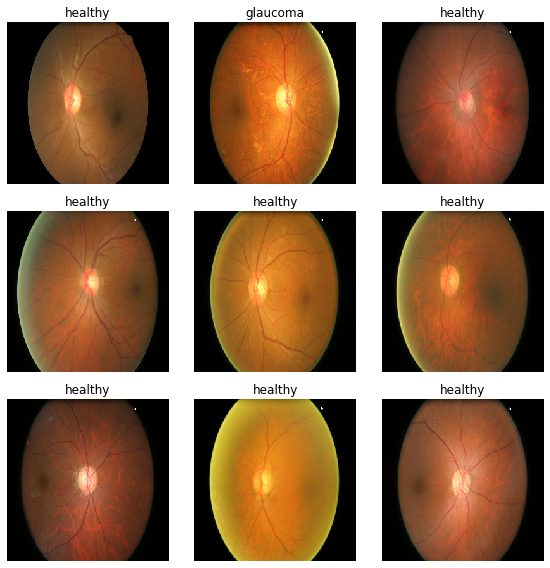

In [0]:
data.show_batch(rows=3, figsize=(8,8))

In [0]:
#Define the two classes
data.classes, data.c

(['glaucoma', 'healthy'], 2)

In [0]:
# Lenght of train dataset
len(data.train_ds)

466

In [0]:
# Lenght of validation dataset
len(data.valid_ds)

116

# Transfer Learning - resnet50

### To save the best model

In [0]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if self.best_acc == None or acc > self.best_acc:
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best accuracy {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Accuracy is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

### **Completely Frozen model**



In [0]:
learn = cnn_learner(data, 
                    models.resnet50,       
                    metrics=accuracy)

In [0]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
0,1.358877,0.756279,0.633588,01:19
1,1.091960,0.835373,0.648855,01:19
2,0.983782,0.813801,0.641221,01:20
3,0.884061,0.924020,0.641221,01:19
4,0.780933,0.820654,0.709924,01:20
5,0.666905,0.838932,0.687023,01:20
6,0.550769,0.925168,0.702290,01:20
7,0.499505,0.997847,0.633588,01:20
8,0.486044,0.882412,0.694656,01:20
9,0.417775,0.898306,0.725191,01:19


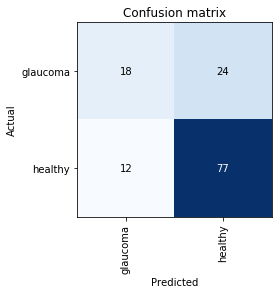

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### **Completely Unfrozen**

In [0]:
learn_unfreeze = cnn_learner(data, 
                             models.resnet50,       
                             metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


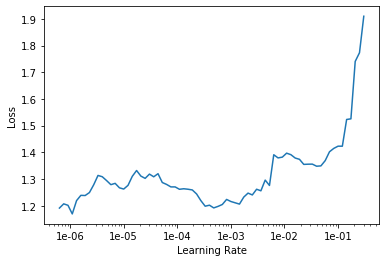

In [0]:
learn_unfreeze.lr_find()
learn_unfreeze.recorder.plot()

In [0]:
learn_unfreeze.unfreeze()

In [0]:
learn_unfreeze.fit_one_cycle(50) 

epoch,train_loss,valid_loss,accuracy,time
0,1.290982,0.791889,0.656489,00:57
1,1.085547,0.796483,0.687023,00:52
2,0.920306,1.011348,0.679389,00:52
3,0.794016,0.829992,0.687023,00:52
4,0.701183,1.081627,0.687023,00:51
5,0.621543,0.946262,0.717557,00:52
6,0.607863,1.785959,0.572519,00:52
7,0.644967,1.106477,0.709924,00:52
8,0.568294,1.042662,0.687023,00:52
9,0.478984,1.003615,0.694656,00:52


In [0]:
interp = ClassificationInterpretation.from_learner(learn_unfreeze)
interp.plot_confusion_matrix()

### **Freezing the last two layers (Classifier + last convolutional layer).**



In [0]:
learn = cnn_learner(data, 
                    models.resnet50,       
                    metrics=accuracy,callback_fns=SaveBestModel)

In [0]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [0]:
learn.freeze_to(-2)

In [0]:
learn.layer_groups

In [0]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,1.324988,0.742775,0.633588,01:31
1,1.116722,0.826419,0.633588,01:22
2,0.922786,0.988073,0.641221,01:22
3,0.772513,1.225517,0.679389,01:22
4,0.690774,1.211944,0.557252,01:22
5,0.585509,0.845759,0.702290,01:21
6,0.521287,1.568846,0.740458,01:22
7,0.460467,1.674283,0.725191,01:20
8,0.458354,0.835757,0.664122,01:20


Save the best accuracy 0.63359
Save the best accuracy 0.64122
Save the best accuracy 0.67939
Save the best accuracy 0.70229
Save the best accuracy 0.74046
Accuracy is eq,Save the lower loss 1.24565
Save the best accuracy 0.79389
Save the best accuracy 0.84733


In [0]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 32, 32]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
______________________________________________________________________
MaxPool2d            [64, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [64, 16, 16]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 16, 16]         128        True      
______________________________________________________________________
Conv2d               [64, 16, 16]         36,864     False     
___________________________________________________

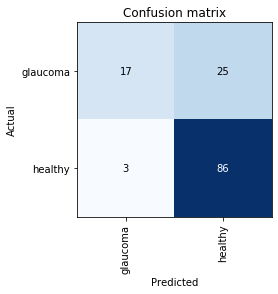

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
import torch
import torch.nn as nn
from torchvision import models

original_model = models.resnet50(pretrained=True)

class ResnetFeature(nn.Module):
            def __init__(self):
                super(ResnetFeature, self).__init__()
                self.features = nn.Sequential(
                    # stop at conv4
                    *list(original_model.children())[:-1]
                   # *list(original_model.features.children())
                )
            def forward(self, x):
                x = self.features(x)
                return x

model = ResnetFeature()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
model_dict = model.state_dict()
pretrained_dict = torch.load('/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/First_Branch/orig/models/best_model.pth',map_location=torch.device('cpu'))
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict)
# 3. load the new state dict
model.load_state_dict(model_dict)
model.eval()

ResnetFeature(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [0]:
import cv2
from PIL import Image
from torchvision import transforms
def featuremap(path_image):
  print(path_image)
  img = cv2.imread(path_image)
  trans = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
  img = trans(img)
  img = img.unsqueeze(0) 
  output = model(img)
  featuremap = output.squeeze(0)
  return featuremap

### Feature extraction of the whole dataset

In [0]:
# To get the images in the same order than google drive.
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [0]:
images_glaucoma = sorted_alphanumeric(os.listdir(path_glaucoma))
images_healthy = sorted_alphanumeric(os.listdir(path_healthy))

Glaucoma Features

In [0]:
with open('/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/First_Branch/orig/feature_extraction_glaucoma.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for name in images_glaucoma:
      writer.writerow(featuremap(str(path_glaucoma)+"/"+name).detach().numpy().tolist())

/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/glaucoma/Magrabia_FeMale_roi_resized_1.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/glaucoma/Magrabia_FeMale_roi_resized_2.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/glaucoma/Magrabia_FeMale_roi_resized_3.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/glaucoma/Magrabia_FeMale_roi_resized_4.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/glaucoma/Magrabia_FeMale_roi_resized_5.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/glaucoma/Magrabia_FeMale_roi_resized_6.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/glaucoma/Magrabia_FeMale_roi_resized_7.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/glaucoma/Magrabia_FeMale_roi_resized_8.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/ou

Healthy Features

In [0]:
with open('/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/First_Branch/orig/feature_extraction_healthy.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for name in images_healthy:
      writer.writerow(featuremap(str(path_healthy)+"/"+name).detach().numpy().tolist())

/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/healthy/healthy_roi_resized_1.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/healthy/healthy_roi_resized_2.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/healthy/healthy_roi_resized_3.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/healthy/healthy_roi_resized_4.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/healthy/healthy_roi_resized_5.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/healthy/healthy_roi_resized_6.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/healthy/healthy_roi_resized_7.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/healthy/healthy_roi_resized_8.png
/content/gdrive/Shared drives/CRP drive private/Second Branch/output_rcnn/healthy/healthy_roi_resized_9.png
/content/gdrive/Shared drive

# Loading Final Dataset - Feature Extraction

In [0]:
glaucoma_feature_dataset=pd.read_csv("/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/First_Branch/orig/feature_extraction_glaucoma.csv", header=None)

NameError: ignored

In [0]:
healthy_feature_dataset=pd.read_csv("/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/First_Branch/orig/feature_extraction_healthy.csv", header=None)

In [0]:
glaucoma_feature_dataset.head()

In [0]:
glaucoma_feature_dataset.shape

(94, 2048)

In [0]:
healthy_feature_dataset.head()

In [0]:
healthy_feature_dataset.shape